In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, average_precision_score, confusion_matrix, 
                             classification_report, precision_recall_curve, fbeta_score)
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.calibration import calibration_curve

from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


import warnings
warnings.filterwarnings('ignore')

# Set style for better looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]

In [28]:
df = pd.read_csv('ds-ca-3-q-1/train_data.csv')
df_test = pd.read_csv('ds-ca-3-q-1/test_data.csv')

In [29]:
len(df_test)

4467

In [30]:
df.columns

Index(['id', 'Birth_Date', 'Weight', 'Height', 'Urban_Rural', 'Occupation',
       'Insurance_Type', 'Family_History', 'Cancer_Type', 'Stage_at_Diagnosis',
       'Diagnosis_Date', 'Symptoms', 'Tumor_Size', 'Surgery_Date',
       'Chemotherapy_Drugs', 'Radiation_Sessions', 'Immunotherapy',
       'Targeted_Therapy', 'Recurrence_Status', 'Smoking_History',
       'Alcohol_Use', 'label'],
      dtype='object')

In [31]:
df.head()

,id,Birth_Date,Weight,Height,Urban_Rural,Occupation,Insurance_Type,Family_History,Cancer_Type,Stage_at_Diagnosis,...,Tumor_Size,Surgery_Date,Chemotherapy_Drugs,Radiation_Sessions,Immunotherapy,Targeted_Therapy,Recurrence_Status,Smoking_History,Alcohol_Use,label
0,1,1994-07-01,64.9,155.0cm,Urban,Unemployed,UEBMI,No,Breast,II,...,8.0,2024-10-19,"Paclitaxel,Docetaxel,Doxorubicin",16,No,Yes,NO,Never,Regular,1
1,2,1992-07-16,61.4,171.0cm,Urban,Factory Worker,UEBMI,Yes,Breast,I,...,10.0,2021-02-28,"Cyclophosphamide,Paclitaxel,Doxorubicin,Docetaxel",10,No,No,Yes,Former,Regular,1
2,3,1948-06-23,60.7,170.0cm,Rural,Unemployed,NRCMS,No,Stomach,IV,...,13.0,2022-09-25,"Fluorouracil,Cisplatin",21,Yes,No,NO,Former,Never,0
3,4,1954-11-26,70.2,171.0cm,Urban,Farmer,URBMI,Yes,Cervical,IV,...,3.0,2024-09-13,Cisplatin,10,No,Yes,NO,Never,Regular,1
4,5,1979-07-08,100.3,186.0cm,Rural,Office Worker,Self-pay,Yes,Lung,II,...,12.0,2023-12-08,"Gemcitabine,Carboplatin",6,Yes,No,Yes,Former,Never,0


In [32]:
df.isna().sum()

id                       0
Birth_Date               0
Weight                   0
Height                   0
Urban_Rural              0
Occupation               0
Insurance_Type           0
Family_History           0
Cancer_Type              0
Stage_at_Diagnosis       0
Diagnosis_Date           0
Symptoms               501
Tumor_Size               0
Surgery_Date          7575
Chemotherapy_Drugs    4050
Radiation_Sessions       0
Immunotherapy            0
Targeted_Therapy         0
Recurrence_Status        0
Smoking_History          0
Alcohol_Use              0
label                    0
dtype: int64

In [33]:
def show_unique_values(df):
    for column in ['Urban_Rural', 'Occupation',
       'Insurance_Type', 'Family_History', 'Cancer_Type', 'Stage_at_Diagnosis',
       'Radiation_Sessions', 'Immunotherapy',
       'Targeted_Therapy', 'Recurrence_Status', 'Smoking_History',
       'Alcohol_Use', 'label']:
        unique_vals = df[column].unique()
        print(f"Column: {column}")
        print(f"Unique Values: {unique_vals}")

# Run the function
show_unique_values(df)

Column: Urban_Rural
Unique Values: ['Urban' 'Rural']
Column: Occupation
Unique Values: ['Unemployed' 'Factory Worker' 'Farmer' 'Office Worker' 'Retired']
Column: Insurance_Type
Unique Values: ['UEBMI' 'NRCMS' 'URBMI' 'Self-pay']
Column: Family_History
Unique Values: ['No' 'Yes']
Column: Cancer_Type
Unique Values: ['Breast' 'Stomach' 'Cervical' 'Lung' 'Esophageal' 'Colorectal' 'Liver']
Column: Stage_at_Diagnosis
Unique Values: ['II' 'I' 'IV' 'III']
Column: Radiation_Sessions
Unique Values: [16 10 21  6 13  4 26 14  7 28  1  0  5 19 27 25 18 17 15 12  8  3  9 24
 11  2 20 23 29 22]
Column: Immunotherapy
Unique Values: ['No' 'Yes']
Column: Targeted_Therapy
Unique Values: ['Yes' 'No']
Column: Recurrence_Status
Unique Values: ['NO' 'Yes']
Column: Smoking_History
Unique Values: ['Never' 'Former' 'Current']
Column: Alcohol_Use
Unique Values: ['Regular' 'Never' 'Occasional']
Column: label
Unique Values: [1 0]


# Preprocessing

In [34]:
# Convert dates to datetime
df['Birth_Date'] = pd.to_datetime(df['Birth_Date'], format='%Y-%m-%d', errors='coerce')
df['Diagnosis_Date'] = pd.to_datetime(df['Diagnosis_Date'], format='%Y-%m-%d', errors='coerce')
df['Surgery_Date'] = pd.to_datetime(df['Surgery_Date'], format='%Y-%m-%d', errors='coerce')

# Check for illogical dates (diagnosis before birth)
invalid_age_mask = df['Diagnosis_Date'] < df['Birth_Date']
print("Illogical dates (diagnosis before birth):", invalid_age_mask.sum())

# Fix the calculate_age function to handle NaTs
def safe_calculate_age(born, diagnosed):
    if pd.isna(born) or pd.isna(diagnosed):
        return np.nan
    if diagnosed < born:  # Diagnosis before birth
        return np.nan
    return diagnosed.year - born.year - ((diagnosed.month, diagnosed.day) < (born.month, born.day))

# Recalculate age
df['Age_at_Diagnosis'] = df.apply(lambda x: safe_calculate_age(x['Birth_Date'], x['Diagnosis_Date']), axis=1)

# Check how many are still missing
df[df['Age_at_Diagnosis'].isna()]

Illogical dates (diagnosis before birth): 0


,id,Birth_Date,Weight,Height,Urban_Rural,Occupation,Insurance_Type,Family_History,Cancer_Type,Stage_at_Diagnosis,...,Surgery_Date,Chemotherapy_Drugs,Radiation_Sessions,Immunotherapy,Targeted_Therapy,Recurrence_Status,Smoking_History,Alcohol_Use,label,Age_at_Diagnosis
238,239,NaT,90.1,163.0cm,Urban,Factory Worker,NRCMS,No,Breast,I,...,2022-07-25,"Cisplatin, Paclitaxel",15,No,No,Yes,Current,Never,0,NaN
889,890,NaT,92.9,189.0cm,Rural,Farmer,URBMI,No,Lung,I,...,2017-12-24,Gemcitabine,17,Yes,No,Yes,Former,Occasional,0,NaN
1005,1006,NaT,58.9,183.0cm,Urban,Office Worker,UEBMI,Yes,Stomach,I,...,2015-07-28,"Cisplatin, Paclitaxel",13,No,No,Yes,Never,Never,1,NaN
1560,1561,NaT,57.9,166.0cm,Rural,Factory Worker,NRCMS,No,Breast,III,...,2023-05-20,"Paclitaxel,Cyclophosphamide",15,No,No,Yes,Former,Never,1,NaN
1953,1954,NaT,67.4,158.0cm,Rural,Retired,URBMI,Yes,Stomach,IV,...,2022-09-18,"Cisplatin,Fluorouracil",7,Yes,Yes,Yes,Never,Occasional,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25019,25020,NaT,51.7,182.0cm,Urban,Farmer,URBMI,Yes,Esophageal,II,...,NaT,"Gemcitabine, Carboplatin",18,No,No,NO,Former,Regular,1,NaN
25230,25231,NaT,37.2,156.0cm,Rural,Office Worker,Self-pay,No,Esophageal,II,...,NaT,NaN,0,No,Yes,NO,Former,Occasional,1,NaN
25688,25689,NaT,80.4,183.0cm,Rural,Retired,UEBMI,No,Breast,III,...,NaT,NaN,20,No,No,Yes,Never,Occasional,0,NaN
25985,25986,NaT,54.5,160.0cm,Rural,Retired,URBMI,No,Breast,I,...,NaT,"Gemcitabine, Carboplatin",14,Yes,No,Yes,Never,Never,1,NaN


In [35]:
age_median = df['Age_at_Diagnosis'].median()
df['Age_at_Diagnosis'].fillna(age_median, inplace=True)

In [36]:
# Create IBM
df['Height'] = df['Height'].str.replace('cm', '').astype(float) / 100
df['BMI'] = df['Weight'] / (df['Height'] ** 2)
df['BMI'] = df['BMI'].round(2) 

In [37]:
# Create surgery delay (days between diagnosis and surgery)
df['Surgery_Delay'] = (df['Surgery_Date'] - df['Diagnosis_Date']).dt.days

# Create had_surgery indicator
df['Had_Surgery'] = df['Surgery_Date'].notna().astype(int)

# Create had_chemotherapy indicator
df['Had_Chemotherapy'] = df['Chemotherapy_Drugs'].notna().astype(int)

# Create symptom count
df['Symptom_Count'] = df['Symptoms'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)

# Create drug count
df['Drug_Count'] = df['Chemotherapy_Drugs'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)

In [38]:
stage_map = {'I': 1, 'II': 2, 'III': 3, 'IV': 4}
df['Stage_Ordinal'] = df['Stage_at_Diagnosis'].map(stage_map)

In [39]:
## 1. For Chemotherapy Drugs ##

# Split drugs and create list of all unique drugs
all_drugs = set()
df['Chemotherapy_Drugs'].str.split(',').apply(
    lambda x: all_drugs.update([d.strip() for d in x]) 
    if isinstance(x, list) else None
)

print(len(all_drugs))
# Remove empty strings if any
all_drugs = {d for d in all_drugs if d}

# Create binary columns for each drug
for drug in sorted(all_drugs):
    col_name = f"Drug_{drug.replace(' ', '_')}"
    df[col_name] = df['Chemotherapy_Drugs'].apply(
        lambda x: 1 if pd.notna(x) and drug in [d.strip() for d in x.split(',')] else 0
    )

## 2. For Symptoms ##

# Split symptoms and create list of all unique symptoms
all_symptoms = set()
df['Symptoms'].str.split(',').apply(
    lambda x: all_symptoms.update([s.strip() for s in x]) 
    if isinstance(x, list) else None
)
print(len(all_symptoms))
# Remove empty strings if any
all_symptoms = {s for s in all_symptoms if s}

# Create binary columns for each symptom
for symptom in sorted(all_symptoms):
    col_name = f"Symptom_{symptom.replace(' ', '_')}"
    df[col_name] = df['Symptoms'].apply(
        lambda x: 1 if pd.notna(x) and symptom in [s.strip() for s in x.split(',')] else 0
    )

12
9


# Visulaization for insights

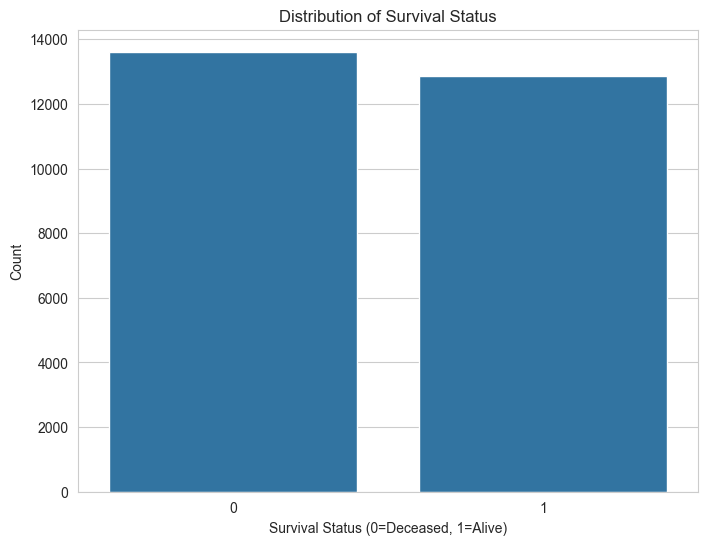

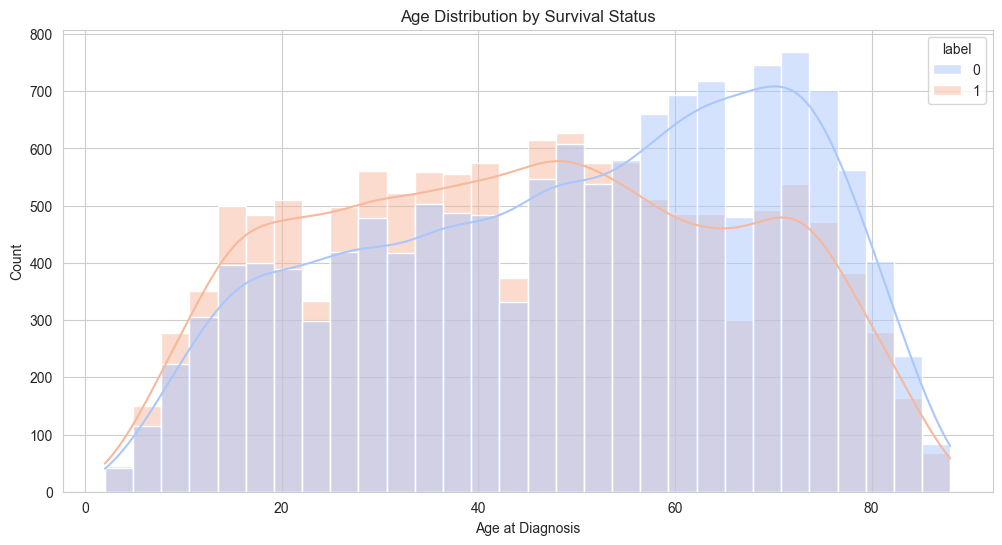

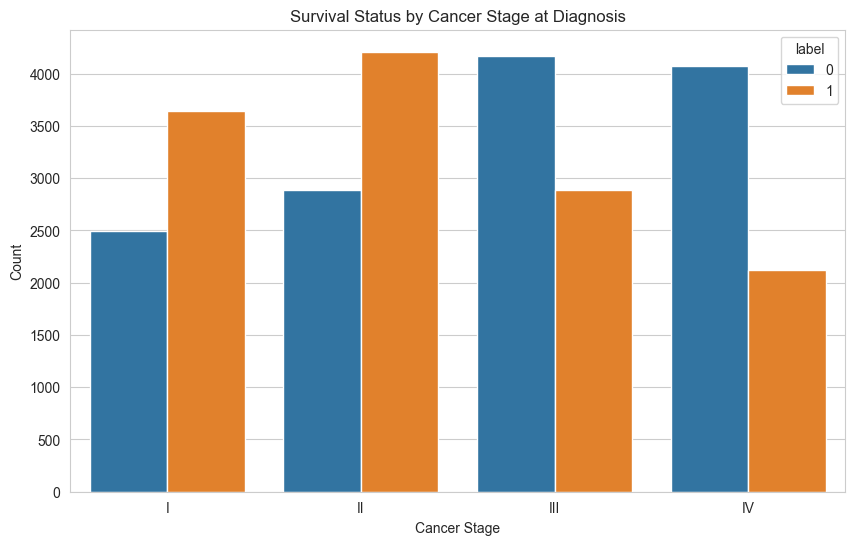

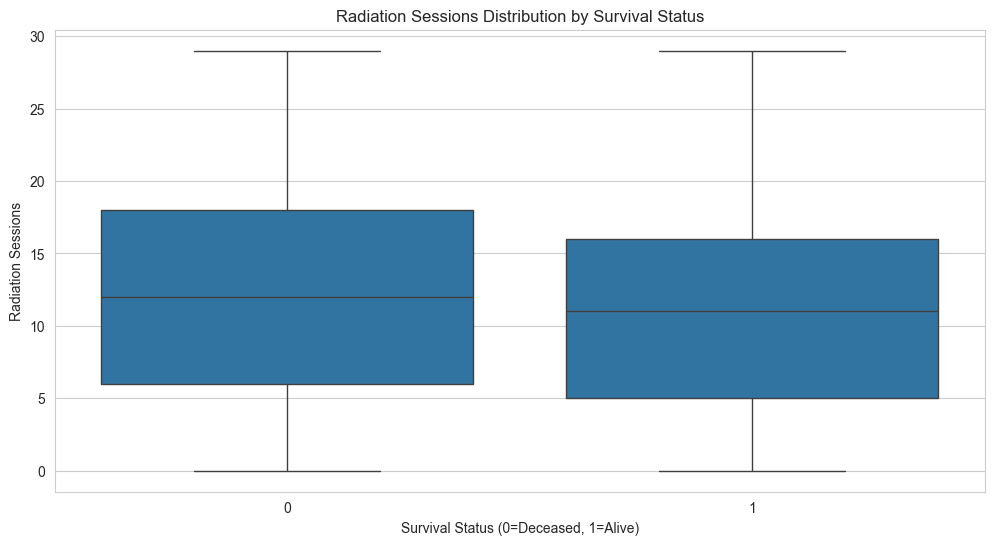

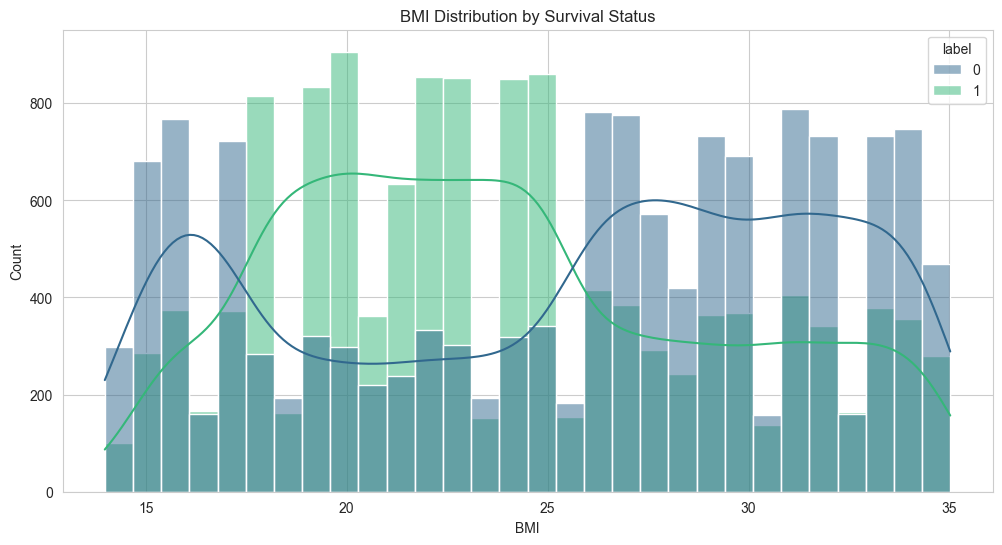

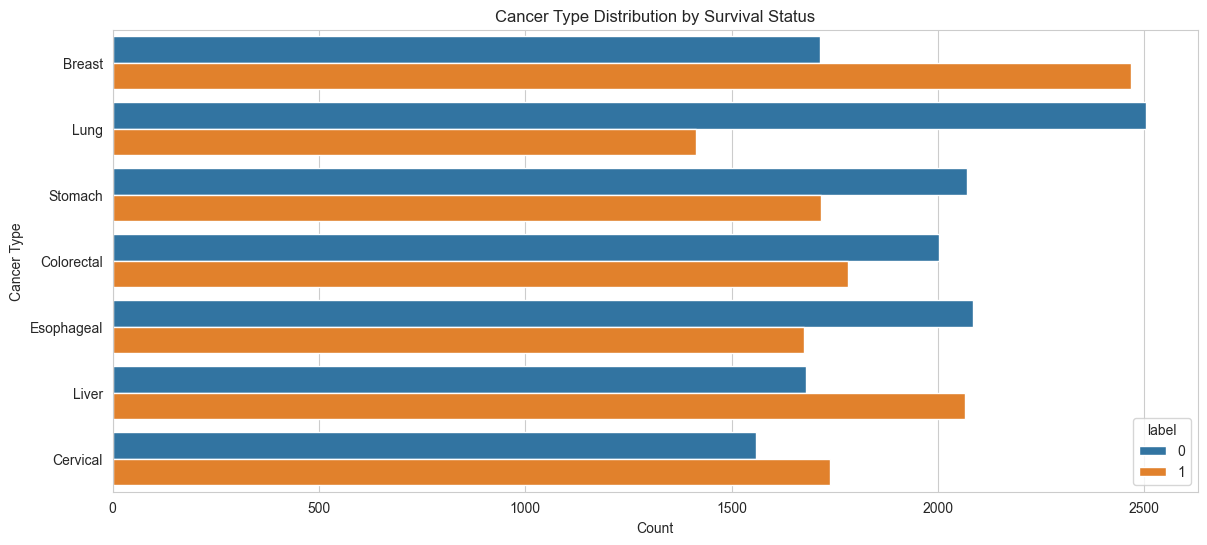

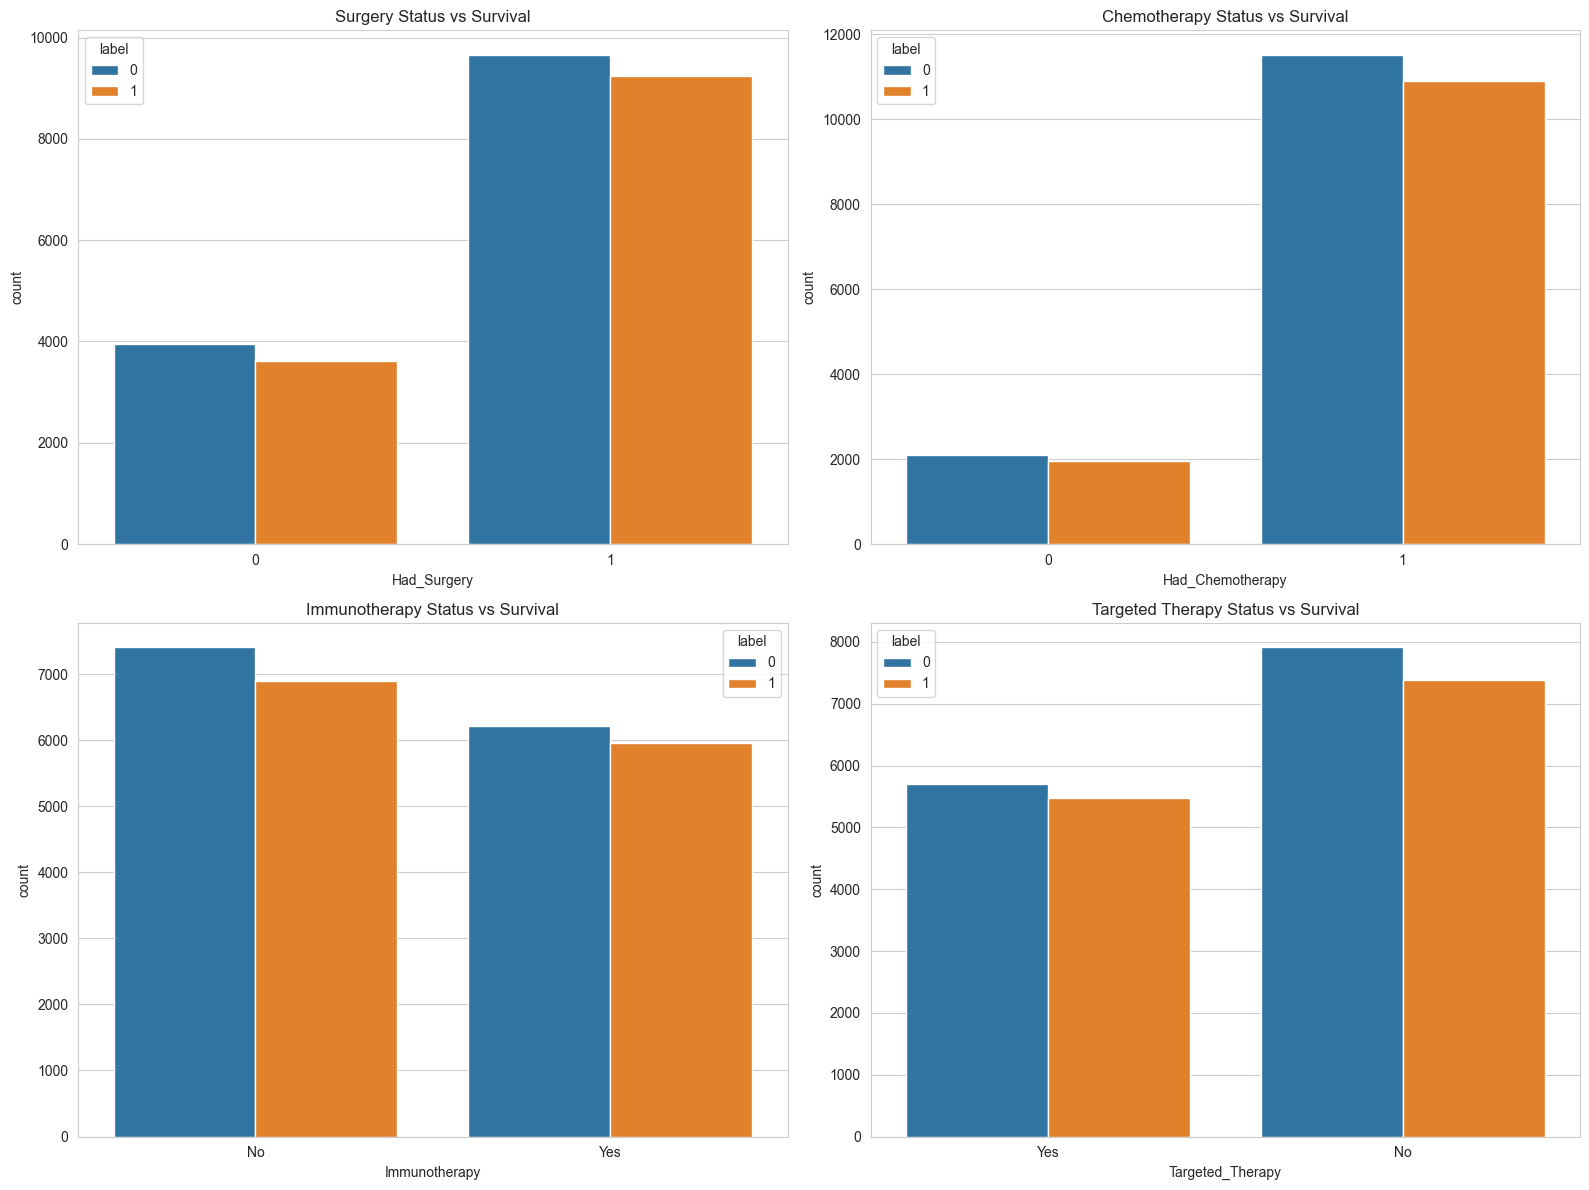

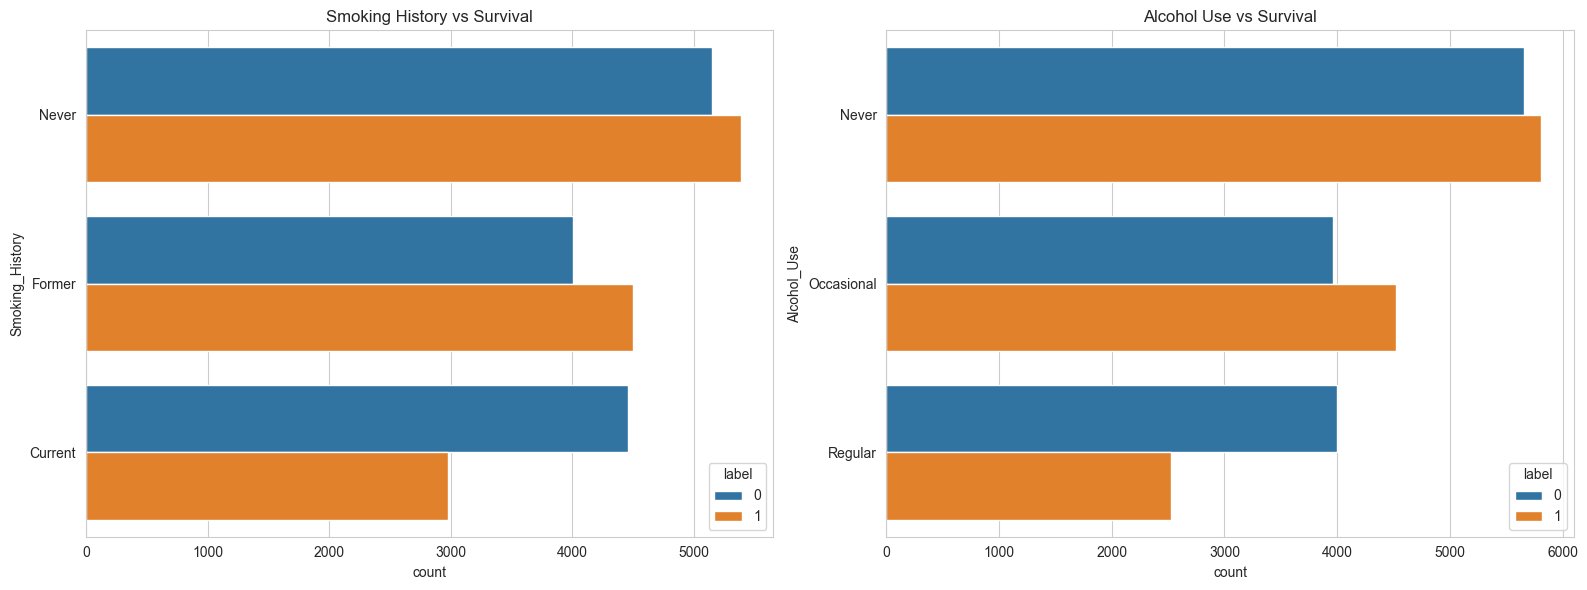

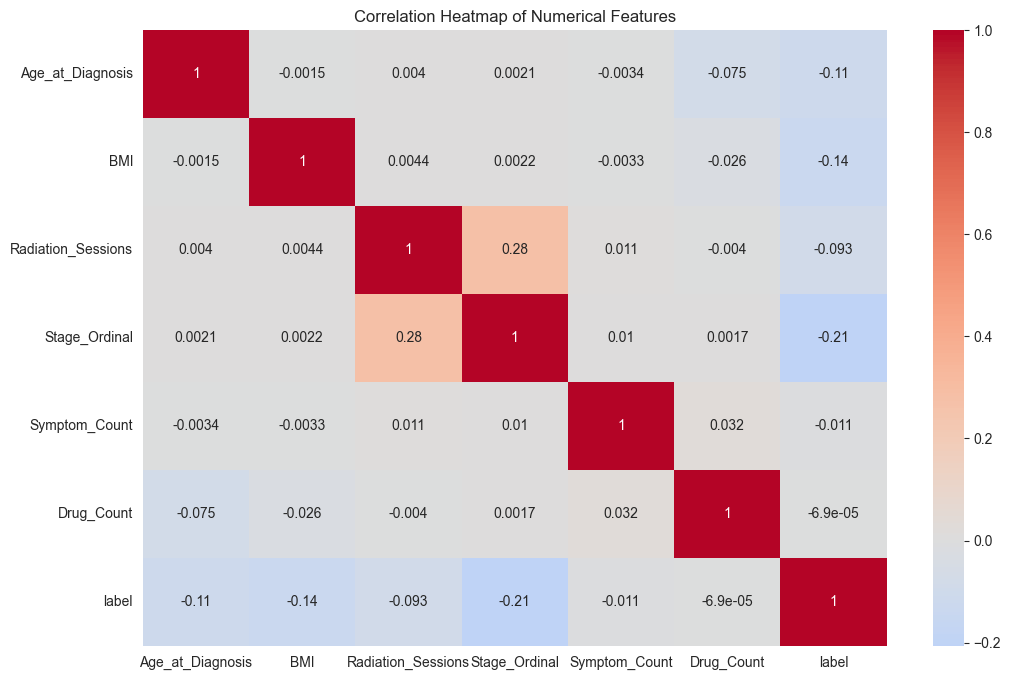

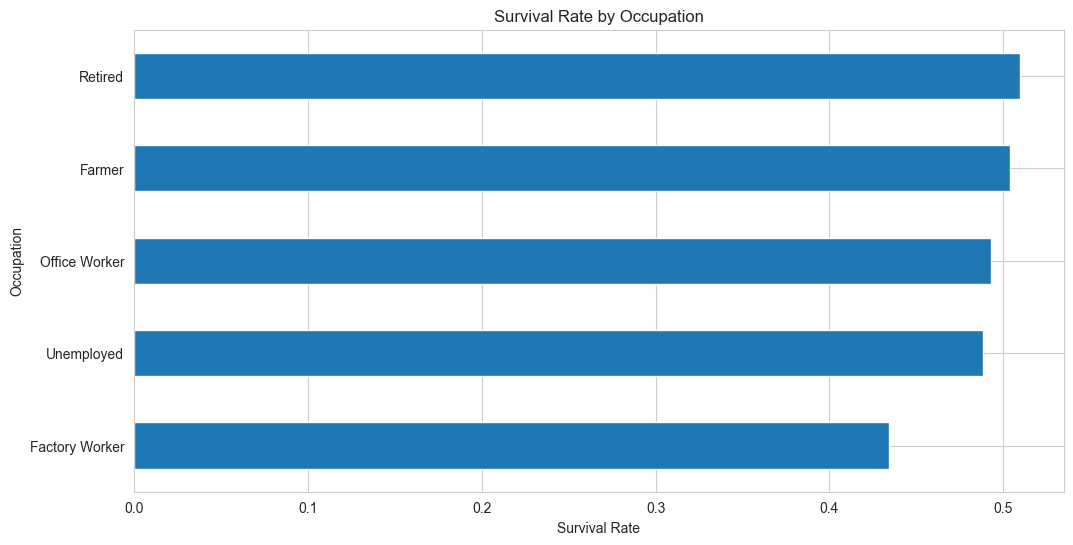

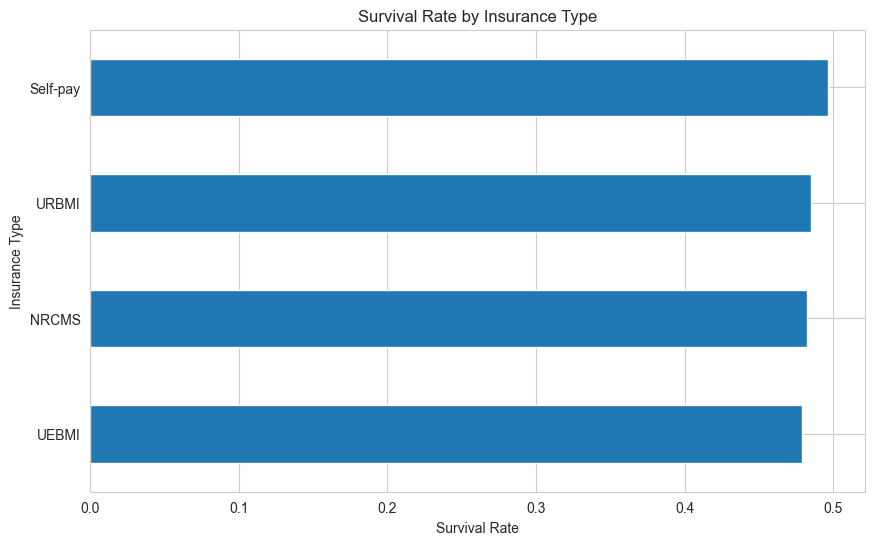

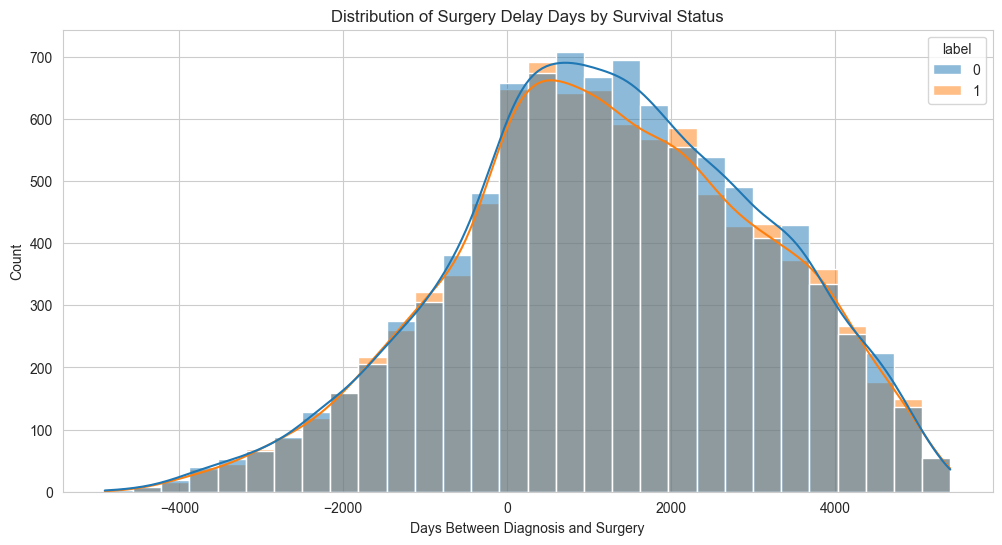

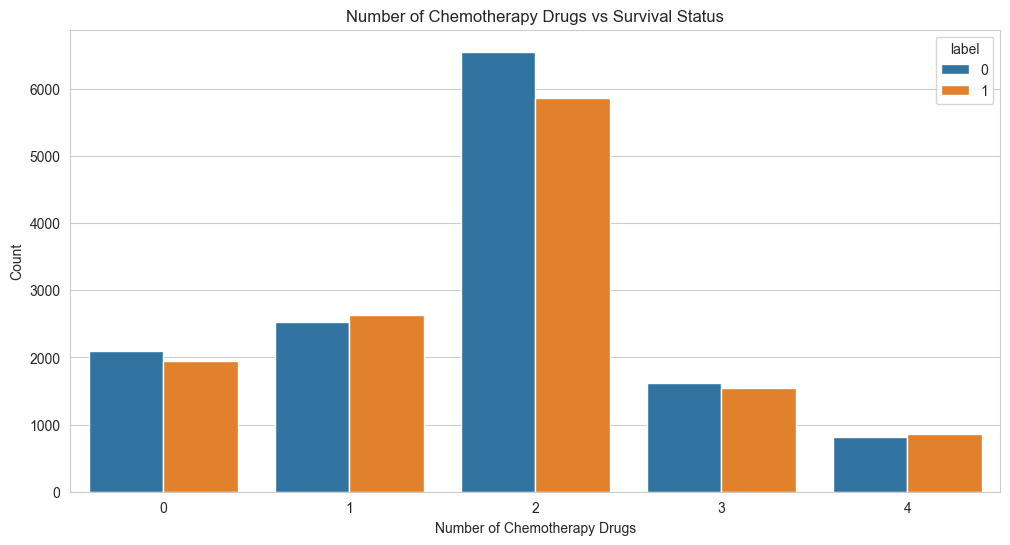

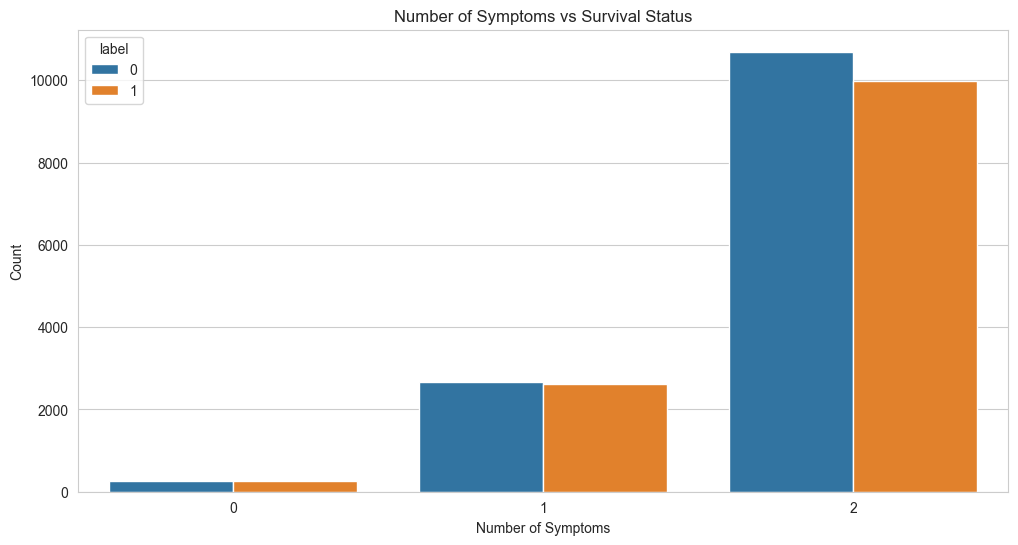

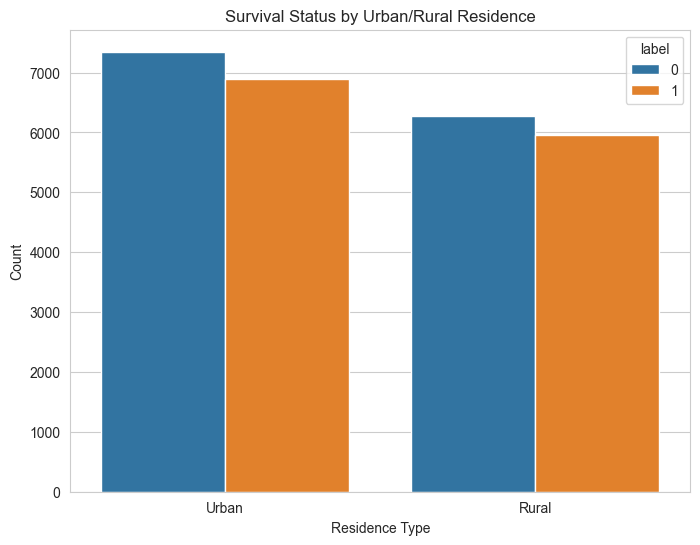

In [40]:
### 1. Target Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title('Distribution of Survival Status')
plt.xlabel('Survival Status (0=Deceased, 1=Alive)')
plt.ylabel('Count')
plt.show()

### 2. Age Distribution by Survival Status
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Age_at_Diagnosis', hue='label', kde=True, bins=30, palette='coolwarm')
plt.title('Age Distribution by Survival Status')
plt.xlabel('Age at Diagnosis')
plt.ylabel('Count')
plt.show()

### 3. Cancer Stage vs Survival
plt.figure(figsize=(10, 6))
sns.countplot(x='Stage_at_Diagnosis', hue='label', data=df, order=['I', 'II', 'III', 'IV'])
plt.title('Survival Status by Cancer Stage at Diagnosis')
plt.xlabel('Cancer Stage')
plt.ylabel('Count')
plt.show()

### 4. Radiation Sessions vs Survival
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='Radiation_Sessions', data=df)
plt.title('Radiation Sessions Distribution by Survival Status')
plt.xlabel('Survival Status (0=Deceased, 1=Alive)')
plt.ylabel('Radiation Sessions')
plt.show()

### 5. BMI Distribution by Survival
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='BMI', hue='label', kde=True, bins=30, palette='viridis')
plt.title('BMI Distribution by Survival Status')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.show()

### 6. Cancer Type Distribution by Survival
plt.figure(figsize=(14, 6))
sns.countplot(y='Cancer_Type', hue='label', data=df, order=df['Cancer_Type'].value_counts().index)
plt.title('Cancer Type Distribution by Survival Status')
plt.ylabel('Cancer Type')
plt.xlabel('Count')
plt.show()

### 7. Treatment Modalities vs Survival
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.countplot(x='Had_Surgery', hue='label', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Surgery Status vs Survival')

sns.countplot(x='Had_Chemotherapy', hue='label', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Chemotherapy Status vs Survival')

sns.countplot(x='Immunotherapy', hue='label', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Immunotherapy Status vs Survival')

sns.countplot(x='Targeted_Therapy', hue='label', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Targeted Therapy Status vs Survival')

plt.tight_layout()
plt.show()

### 8. Lifestyle Factors
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.countplot(y='Smoking_History', hue='label', data=df, ax=axes[0], order=['Never', 'Former', 'Current'])
axes[0].set_title('Smoking History vs Survival')

sns.countplot(y='Alcohol_Use', hue='label', data=df, ax=axes[1], order=['Never', 'Occasional', 'Regular'])
axes[1].set_title('Alcohol Use vs Survival')

plt.tight_layout()
plt.show()

### 9. Correlation Heatmap (for numerical features)
numerical_features = ['Age_at_Diagnosis', 'BMI', 'Radiation_Sessions', 'Stage_Ordinal', 
                     'Symptom_Count', 'Drug_Count', 'label']
plt.figure(figsize=(12, 8))
corr_matrix = df[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

### 10. Survival Rate by Occupation
occupation_survival = df.groupby('Occupation')['label'].mean().sort_values()
plt.figure(figsize=(12, 6))
occupation_survival.plot(kind='barh')
plt.title('Survival Rate by Occupation')
plt.xlabel('Survival Rate')
plt.ylabel('Occupation')
plt.show()

### 11. Survival Rate by Insurance Type
insurance_survival = df.groupby('Insurance_Type')['label'].mean().sort_values()
plt.figure(figsize=(10, 6))
insurance_survival.plot(kind='barh')
plt.title('Survival Rate by Insurance Type')
plt.xlabel('Survival Rate')
plt.ylabel('Insurance Type')
plt.show()

### 12. Time Between Diagnosis and Surgery (for patients who had surgery)
if df['Had_Surgery'].sum() > 0:
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df[df['Had_Surgery']==1], x='Surgery_Delay', hue='label', kde=True, bins=30)
    plt.title('Distribution of Surgery Delay Days by Survival Status')
    plt.xlabel('Days Between Diagnosis and Surgery')
    plt.ylabel('Count')
    plt.show()

### 13. Drug Count vs Survival
plt.figure(figsize=(12, 6))
sns.countplot(x='Drug_Count', hue='label', data=df)
plt.title('Number of Chemotherapy Drugs vs Survival Status')
plt.xlabel('Number of Chemotherapy Drugs')
plt.ylabel('Count')
plt.show()

### 14. Symptom Count vs Survival
plt.figure(figsize=(12, 6))
sns.countplot(x='Symptom_Count', hue='label', data=df)
plt.title('Number of Symptoms vs Survival Status')
plt.xlabel('Number of Symptoms')
plt.ylabel('Count')
plt.show()

### 15. Urban/Rural vs Survival
plt.figure(figsize=(8, 6))
sns.countplot(x='Urban_Rural', hue='label', data=df)
plt.title('Survival Status by Urban/Rural Residence')
plt.xlabel('Residence Type')
plt.ylabel('Count')
plt.show()

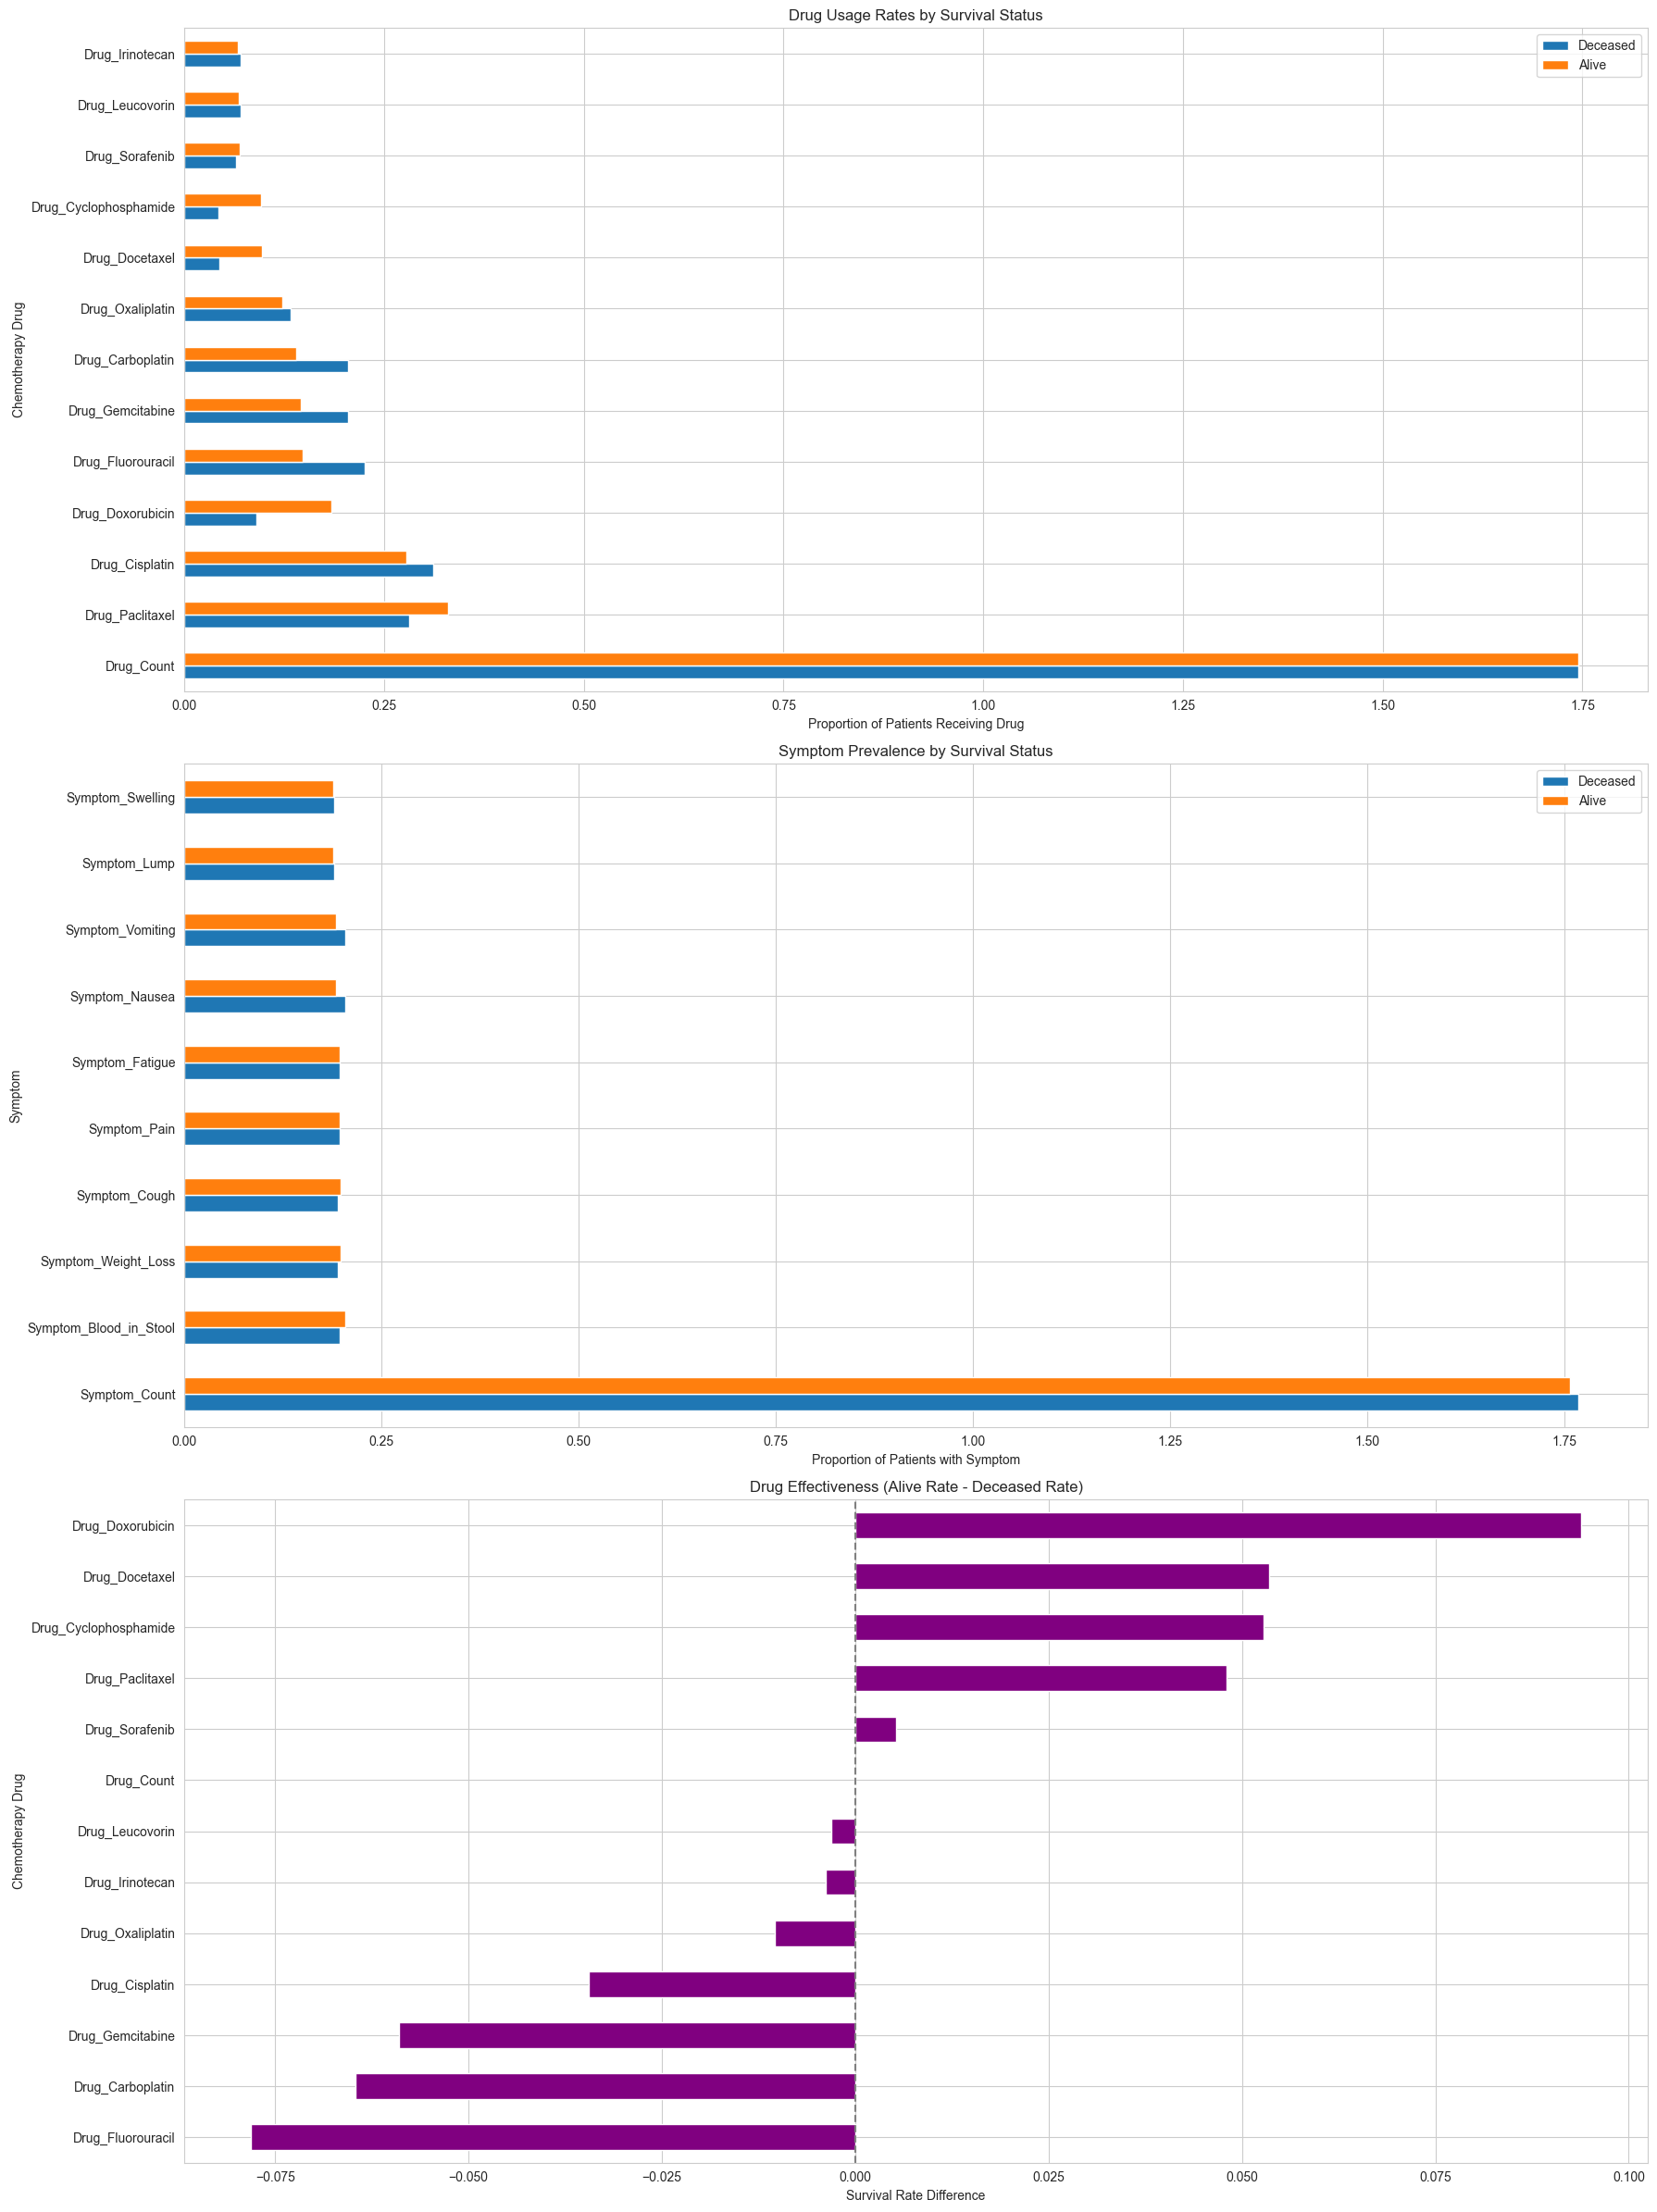

In [41]:
# Set up the figure
plt.figure(figsize=(18, 24))

# Get the top N drugs/symptoms to visualize (avoid overcrowding)
top_drugs = sorted([col for col in df.columns if col.startswith('Drug_')], 
                   key=lambda x: df[x].sum(), reverse=True)[:15]
top_symptoms = sorted([col for col in df.columns if col.startswith('Symptom_')], 
                     key=lambda x: df[x].sum(), reverse=True)[:15]

# Plot drug survival rates
plt.subplot(3, 1, 1)
drug_survival = df.groupby('label')[top_drugs].mean().T.sort_values(1, ascending=False)
drug_survival.plot(kind='barh', stacked=False, ax=plt.gca())
plt.title('Drug Usage Rates by Survival Status')
plt.xlabel('Proportion of Patients Receiving Drug')
plt.ylabel('Chemotherapy Drug')
plt.legend(['Deceased', 'Alive'])

# Plot symptom survival rates
plt.subplot(3, 1, 2)
symptom_survival = df.groupby('label')[top_symptoms].mean().T.sort_values(1, ascending=False)
symptom_survival.plot(kind='barh', stacked=False, ax=plt.gca())
plt.title('Symptom Prevalence by Survival Status')
plt.xlabel('Proportion of Patients with Symptom')
plt.ylabel('Symptom')
plt.legend(['Deceased', 'Alive'])

# Plot drug effectiveness (difference between survival groups)
plt.subplot(3, 1, 3)
drug_effect = drug_survival[1] - drug_survival[0]
drug_effect.sort_values().plot(kind='barh', color='purple')
plt.title('Drug Effectiveness (Alive Rate - Deceased Rate)')
plt.xlabel('Survival Rate Difference')
plt.ylabel('Chemotherapy Drug')
plt.axvline(0, color='gray', linestyle='--')

plt.tight_layout()
plt.show()

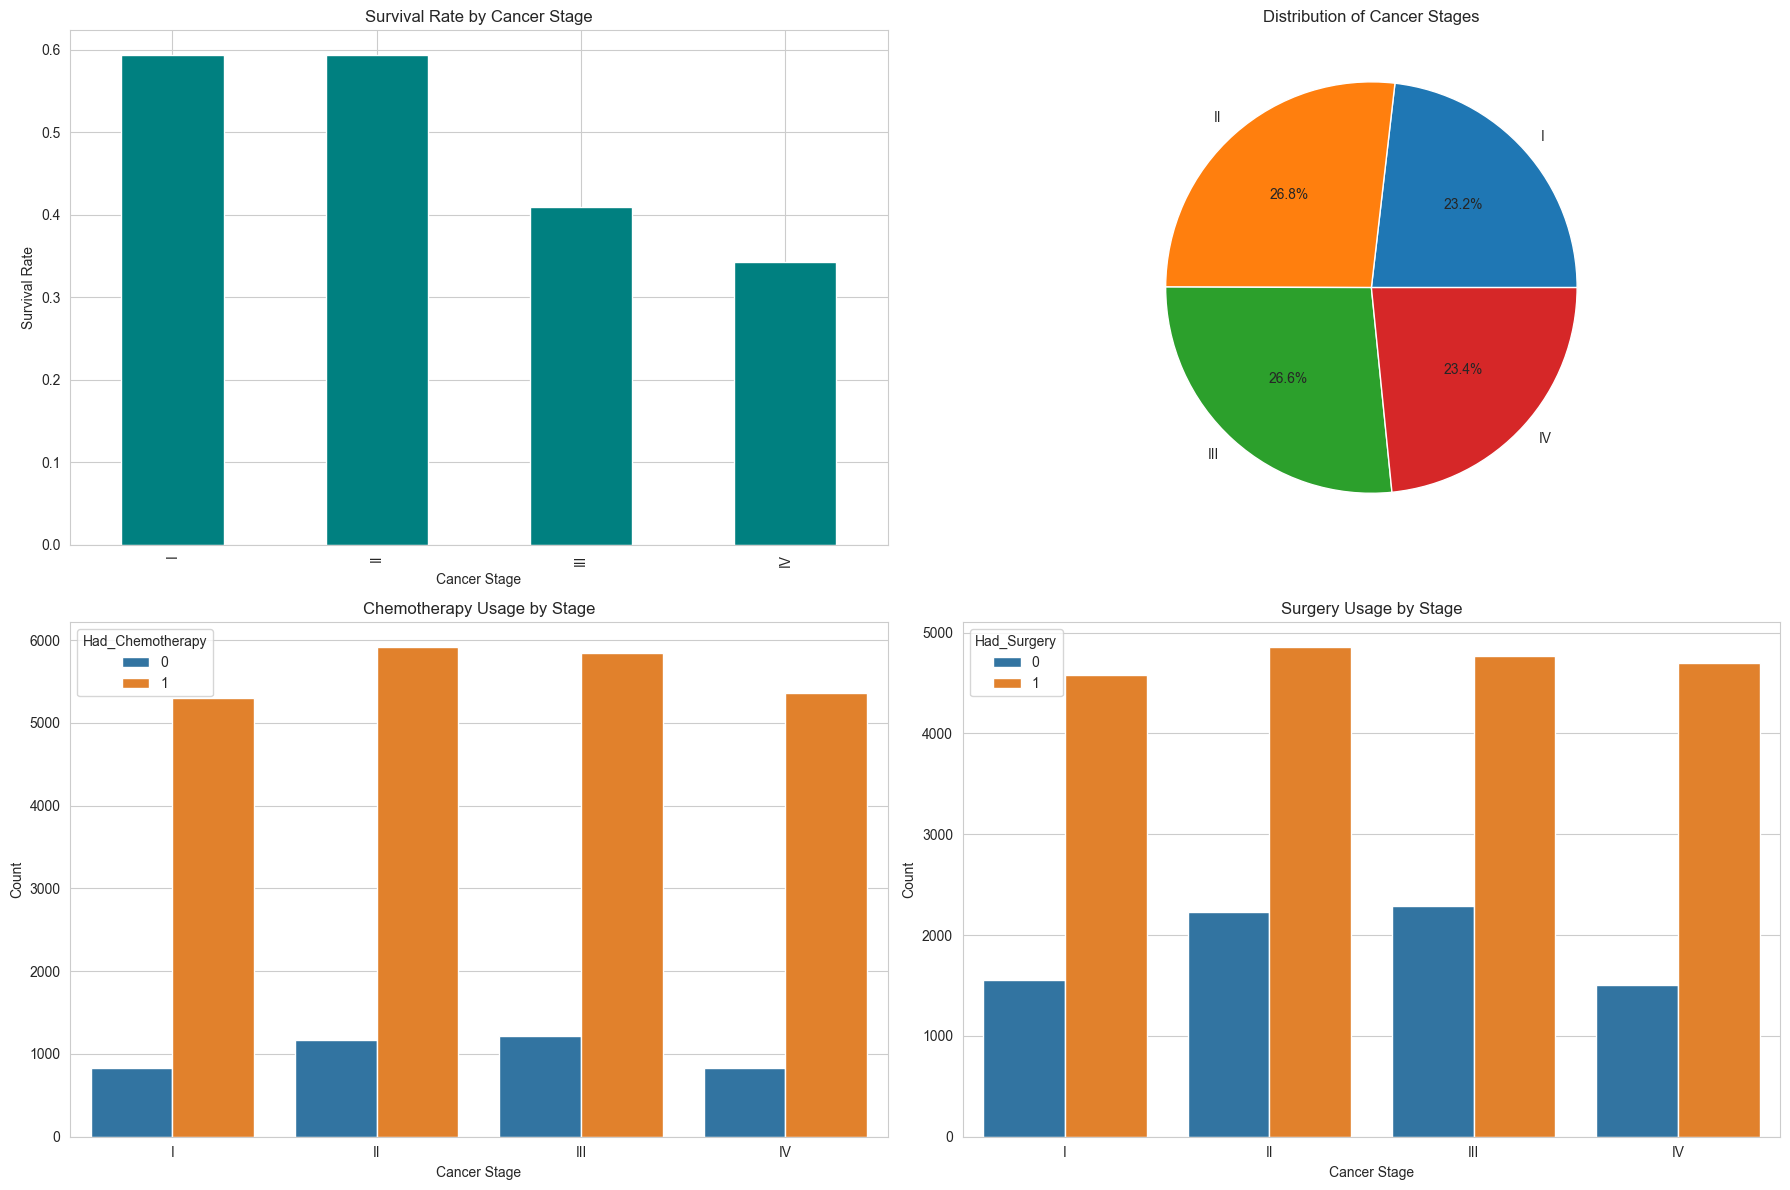

In [42]:
plt.figure(figsize=(18, 12))

# Survival rate by stage
plt.subplot(2, 2, 1)
stage_survival = df.groupby('Stage_at_Diagnosis')['label'].mean().reindex(['I', 'II', 'III', 'IV'])
stage_survival.plot(kind='bar', color='teal')
plt.title('Survival Rate by Cancer Stage')
plt.ylabel('Survival Rate')
plt.xlabel('Cancer Stage')

# Stage distribution
plt.subplot(2, 2, 2)
df['Stage_at_Diagnosis'].value_counts().reindex(['I', 'II', 'III', 'IV']).plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Cancer Stages')
plt.ylabel('')

# Treatment modalities by stage
plt.subplot(2, 2, 3)
sns.countplot(x='Stage_at_Diagnosis', hue='Had_Chemotherapy', data=df, order=['I', 'II', 'III', 'IV'])
plt.title('Chemotherapy Usage by Stage')
plt.xlabel('Cancer Stage')
plt.ylabel('Count')

plt.subplot(2, 2, 4)
sns.countplot(x='Stage_at_Diagnosis', hue='Had_Surgery', data=df, order=['I', 'II', 'III', 'IV'])
plt.title('Surgery Usage by Stage')
plt.xlabel('Cancer Stage')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

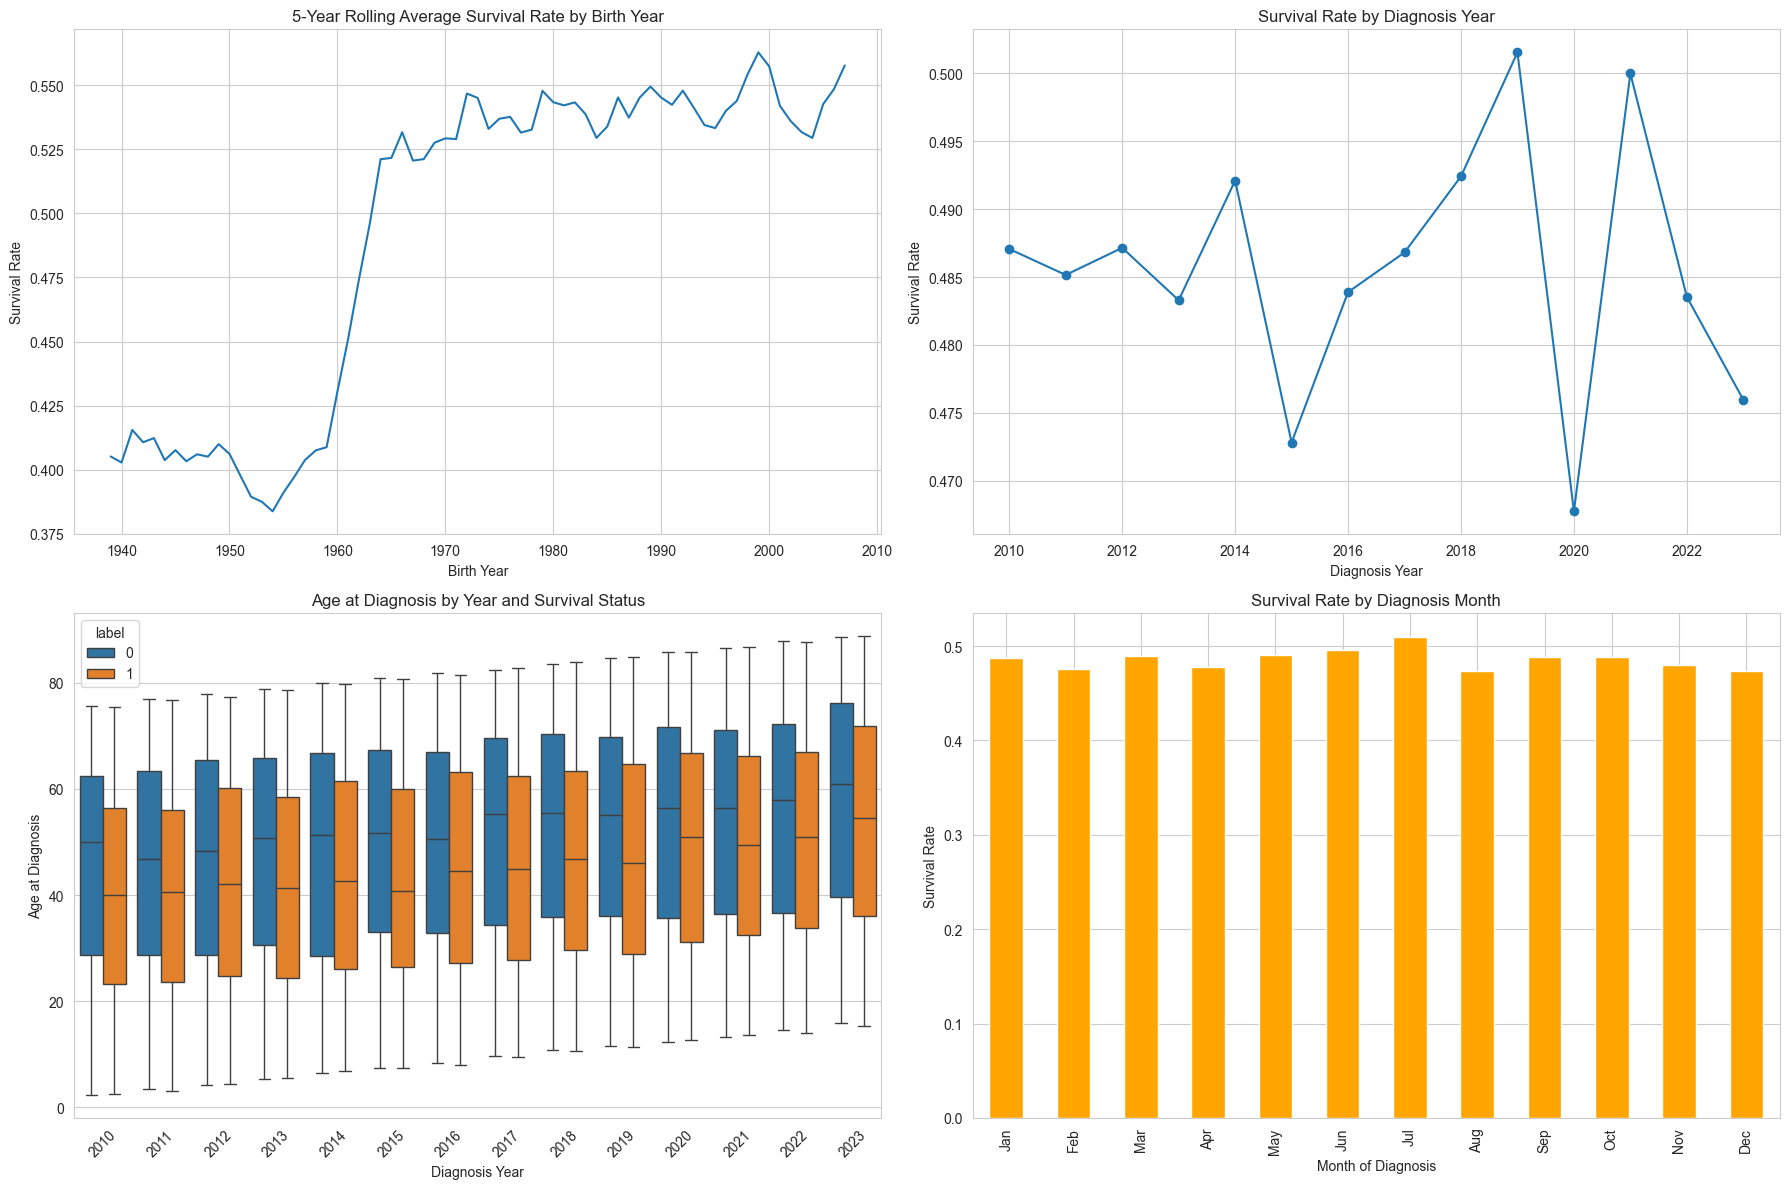

In [43]:
plt.figure(figsize=(18, 12))

# Convert dates to datetime if not already
df['Birth_Date'] = pd.to_datetime(df['Birth_Date'])
df['Diagnosis_Date'] = pd.to_datetime(df['Diagnosis_Date'])

# Birth year analysis
plt.subplot(2, 2, 1)
df['Birth_Year'] = df['Birth_Date'].dt.year
birth_year_survival = df.groupby('Birth_Year')['label'].mean()
birth_year_survival.rolling(5).mean().plot()
plt.title('5-Year Rolling Average Survival Rate by Birth Year')
plt.ylabel('Survival Rate')
plt.xlabel('Birth Year')

# Diagnosis year analysis
plt.subplot(2, 2, 2)
df['Diagnosis_Year'] = df['Diagnosis_Date'].dt.year
diagnosis_year_survival = df.groupby('Diagnosis_Year')['label'].mean()
diagnosis_year_survival.plot(marker='o')
plt.title('Survival Rate by Diagnosis Year')
plt.ylabel('Survival Rate')
plt.xlabel('Diagnosis Year')

# Age at diagnosis trends
plt.subplot(2, 2, 3)
df['Age_at_Diagnosis'] = (df['Diagnosis_Date'] - df['Birth_Date']).dt.days / 365.25
sns.boxplot(x='Diagnosis_Year', y='Age_at_Diagnosis', hue='label', data=df)
plt.title('Age at Diagnosis by Year and Survival Status')
plt.ylabel('Age at Diagnosis')
plt.xlabel('Diagnosis Year')
plt.xticks(rotation=45)

# Monthly diagnosis patterns
plt.subplot(2, 2, 4)
df['Diagnosis_Month'] = df['Diagnosis_Date'].dt.month
monthly_survival = df.groupby('Diagnosis_Month')['label'].mean()
monthly_survival.plot(kind='bar', color='orange')
plt.title('Survival Rate by Diagnosis Month')
plt.ylabel('Survival Rate')
plt.xlabel('Month of Diagnosis')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                      'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

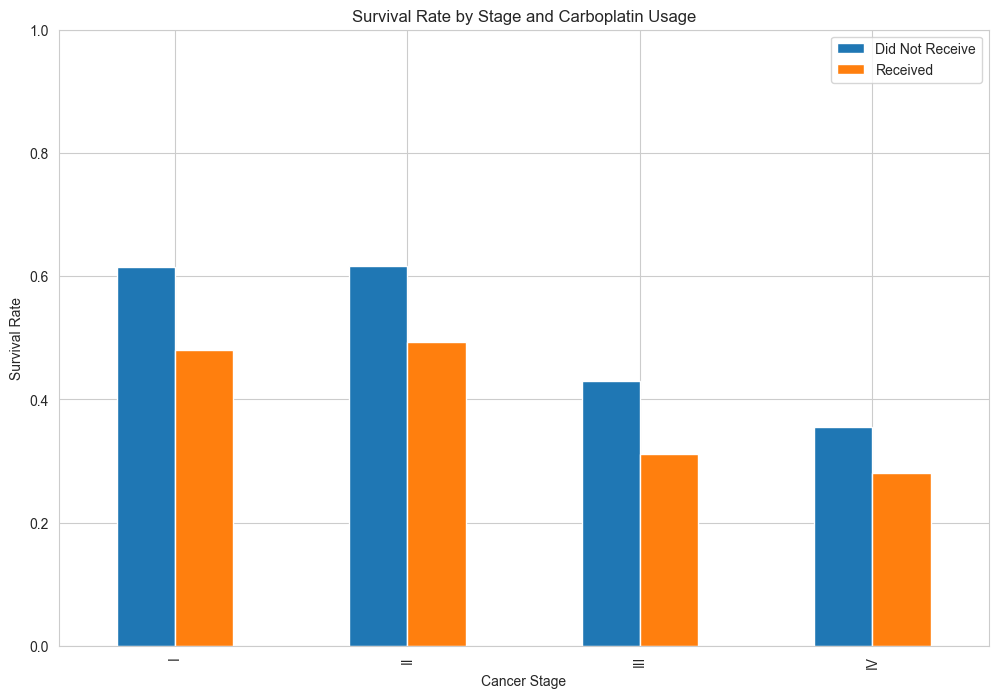

<Figure size 1000x600 with 0 Axes>

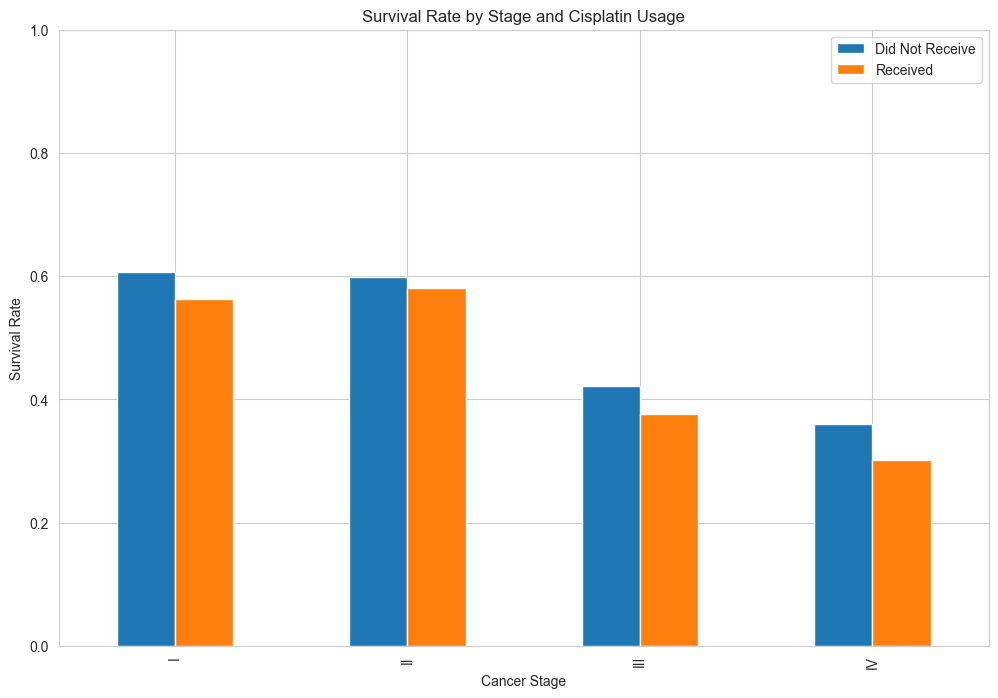

<Figure size 1000x600 with 0 Axes>

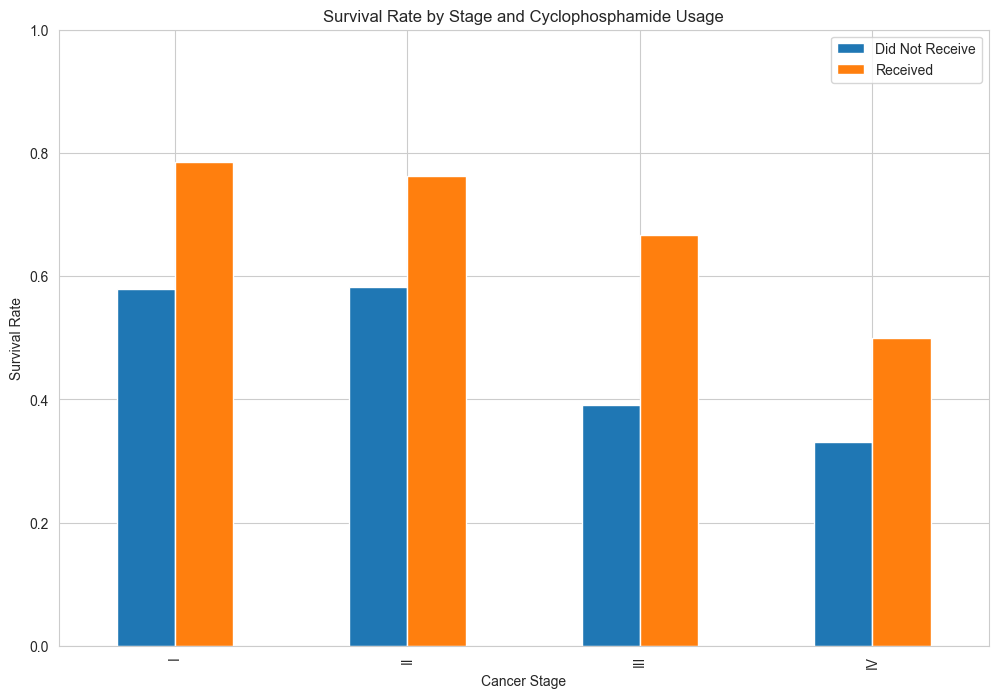

In [44]:
# Create a pivot table for drug effectiveness by stage
top_3_drugs = [col for col in df.columns if col.startswith('Drug_')][1:4]
for drug in top_3_drugs:
    plt.figure(figsize=(10, 6))
    pivot = pd.pivot_table(df, values='label', index='Stage_at_Diagnosis', 
                          columns=drug, aggfunc='mean')
    pivot.plot(kind='bar')
    plt.title(f'Survival Rate by Stage and {drug.replace("Drug_", "")} Usage')
    plt.ylabel('Survival Rate')
    plt.xlabel('Cancer Stage')
    plt.legend(['Did Not Receive', 'Received'])
    plt.ylim(0, 1)
    plt.show()

In [ ]:
useful_features = [
    'Age_at_Diagnosis', 'BMI', 'Urban_Rural', 'Insurance_Type',
    'Cancer_Type', 'Stage_Ordinal', 'Tumor_Size', 'Recurrence_Status',
    'Had_Surgery', 'Had_Chemotherapy', 'Radiation_Sessions',
    'Immunotherapy', 'Targeted_Therapy', 'Drug_Count',
    'Smoking_History', 'Alcohol_Use', 'Diagnosis_Year'
]

df = df.dropna(subset=['Age_at_Diagnosis'])
X = df[useful_features]
y = df['label']

categorical_features = [
    'Cancer_Type',
    'Smoking_History', 'Alcohol_Use'
]

numerical_features = [
    'Age_at_Diagnosis', 'BMI', 'Stage_Ordinal','Tumor_Size',
    'Drug_Count'
]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        # ('binary', 'passthrough', binary_features)
    ],
    verbose_feature_names_out=False
)

# X_train, X_val, y_train, y_val = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y)

X_train = X
y_train = y

# Model Definitions (unchanged)
base_models = {
    # 'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=0.9,
    #                         max_depth=4, subsample=0.7, colsample_bytree=0.7, min_child_weight=3),
    # 'LightGBM': LGBMClassifier(random_state=42, is_unbalance=True, max_depth=4,
    #                          feature_fraction=0.8, lambda_l1=0.2, min_data_in_leaf=20),
    'CatBoost': CatBoostClassifier(random_state=42, auto_class_weights='Balanced',
                                 depth=6, l2_leaf_reg=3, verbose=0),
    # 'RandomForest': RandomForestClassifier(random_state=42, class_weight='balanced_subsample',
    #                                     max_depth=7, n_jobs=-1),
    # 'LogisticRegression': LogisticRegression(class_weight='balanced', penalty='l1',
    #                                        solver='liblinear', C=0.1, random_state=42),
}


Training CatBoost...
[LightGBM] [Info] Number of positive: 10856, number of negative: 10856
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 809
[LightGBM] [Info] Number of data points in the train set: 21712, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 10857, number of negative: 10857
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 811
[LightGBM] [Info] Number of data points in the train set: 21714, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500

<Figure size 1000x400 with 0 Axes>

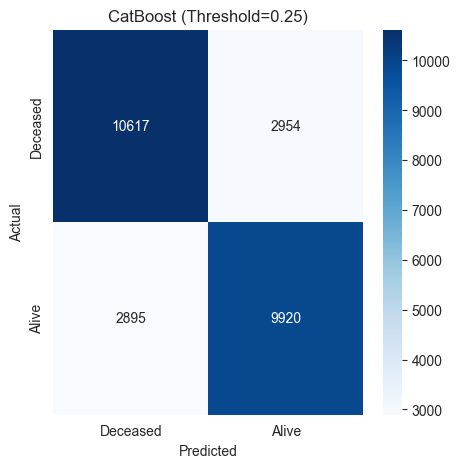

              precision    recall  f1-score   support

    Deceased       0.79      0.78      0.78     13571
       Alive       0.77      0.77      0.77     12815

    accuracy                           0.78     26386
   macro avg       0.78      0.78      0.78     26386
weighted avg       0.78      0.78      0.78     26386


Model Comparison (sorted by Accuracy):
      Model  Accuracy  Precision    Recall        F1   ROC AUC    PR AUC  \
0  CatBoost  0.778329   0.770545  0.774093  0.772315  0.870537  0.875452   

   Threshold  
0   0.252525  
[LightGBM] [Info] Number of positive: 13571, number of negative: 13571
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 27142, number of used features: 18
[LightGBM] [Info] [binary:B

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age_at_Diagnosis', 'BMI',
                                                   'Stage_Ordinal',
                                                   'Tumor_Size',
                                                   'Drug_Count']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Cancer_Type',
                                                   'Smoking_History',
                                                   'Alcohol_Use'])],
                                   verbose_feature_names_out=False)),
                ('smote', SMOTE(random_state=42)),
                ('feature_selection',
                 SelectFromModel(estimator=LGBMClassifier(random_state=42),
                                 threshold='median')),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x0000020B64568700>)])

In [46]:
models = {}
for name, model in base_models.items():
    if name in ['LogisticRegression', 'SVM']:
        models[name] = imbPipeline([
            ('preprocessor', preprocessor),
            ('scaler', StandardScaler(with_mean=False)),
            ('smote', SMOTE(random_state=42)),
            ('feature_selection', SelectFromModel(LGBMClassifier(random_state=42), threshold='median')),
            ('model', model)
        ])
    else:
        models[name] = imbPipeline([
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('feature_selection', SelectFromModel(LGBMClassifier(random_state=42), threshold='median')),
            ('model', model)
        ])


# Improved Evaluation Functions
def find_optimal_threshold(y_true, y_proba, beta=1.5):
    thresholds = np.linspace(0, 1, 100)
    f_scores = [fbeta_score(y_true, (y_proba > t).astype(int), beta=beta) for t in thresholds]
    return thresholds[np.argmax(f_scores)]

def plot_confusion_matrix(y_true, y_pred, title, ax=None):
    cm = confusion_matrix(y_true, y_pred)
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
               xticklabels=['Deceased', 'Alive'],
               yticklabels=['Deceased', 'Alive'])
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

def evaluate_model(y_true, y_proba, model_name):
    # Find optimal threshold
    threshold = find_optimal_threshold(y_true, y_proba)
    y_pred = (y_proba > 0.5).astype(int)
    
    # Calculate metrics
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred),
        'ROC AUC': roc_auc_score(y_true, y_proba),
        'PR AUC': average_precision_score(y_true, y_proba),
        'Threshold': threshold
    }
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 4))
    plot_confusion_matrix(y_true, y_pred, f'{model_name} (Threshold={threshold:.2f})')
    plt.show()
    
    # Print classification report
    print(classification_report(y_true, y_pred, target_names=['Deceased', 'Alive']))
    
    return metrics

# Model Training and Evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for name, pipeline in models.items():
    print(f"\n{'='*50}\nTraining {name}...\n{'='*50}")
    
    # Get cross-validated probabilities
    y_proba = cross_val_predict(pipeline, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
    
    # Evaluate
    metrics = evaluate_model(y_train, y_proba, name)
    results.append({'Model': name, **metrics})

# Final Evaluation
results_df = pd.DataFrame(results)
print("\nModel Comparison (sorted by Accuracy):")
print(results_df.sort_values('Accuracy', ascending=False))

# Evaluate best model on validation set
best_model_name = results_df.sort_values('Accuracy', ascending=False).iloc[0]['Model']
best_model = models[best_model_name]
best_model.fit(X_train, y_train)

# print(f"\n{'='*50}\nEvaluating {best_model_name} on Validation Set\n{'='*50}")
# y_val_proba = best_model.predict_proba(X_val)[:, 1]
# val_metrics = evaluate_model(y_val, y_val_proba, f"{best_model_name} (Validation)")

In [47]:
# Function to safely calculate age
def safe_calculate_age(born, diagnosed):
    if pd.isna(born) or pd.isna(diagnosed) or diagnosed < born:
        return np.nan
    return diagnosed.year - born.year - ((diagnosed.month, diagnosed.day) < (born.month, born.day))

# Apply preprocessing to test dataset
df_test['Birth_Date'] = pd.to_datetime(df_test['Birth_Date'], format='%Y-%m-%d', errors='coerce')
df_test['Diagnosis_Date'] = pd.to_datetime(df_test['Diagnosis_Date'], format='%Y-%m-%d', errors='coerce')
df_test['Surgery_Date'] = pd.to_datetime(df_test['Surgery_Date'], format='%Y-%m-%d', errors='coerce')

df_test['Age_at_Diagnosis'] = df_test.apply(lambda x: safe_calculate_age(x['Birth_Date'], x['Diagnosis_Date']), axis=1)
df_test['Age_at_Diagnosis'].fillna(df_test['Age_at_Diagnosis'].median(), inplace=True)

df_test['Height'] = df_test['Height'].str.replace('cm', '').astype(float) / 100
df_test['BMI'] = df_test['Weight'] / (df_test['Height'] ** 2)
df_test['BMI'] = df_test['BMI'].round(2)

df_test['Surgery_Delay'] = (df_test['Surgery_Date'] - df_test['Diagnosis_Date']).dt.days
df_test['Had_Surgery'] = df_test['Surgery_Date'].notna().astype(int)
df_test['Had_Chemotherapy'] = df_test['Chemotherapy_Drugs'].notna().astype(int)

df_test['Symptom_Count'] = df_test['Symptoms'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)
df_test['Drug_Count'] = df_test['Chemotherapy_Drugs'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)

stage_map = {'I': 1, 'II': 2, 'III': 3, 'IV': 4}
df_test['Stage_Ordinal'] = df_test['Stage_at_Diagnosis'].map(stage_map)

# Generate binary drug features
all_drugs = set()
df_test['Chemotherapy_Drugs'].str.split(',').apply(lambda x: all_drugs.update([d.strip() for d in x]) if isinstance(x, list) else None)
all_drugs = {d for d in all_drugs if d}

for drug in sorted(all_drugs):
    col_name = f"Drug_{drug.replace(' ', '_')}"
    df_test[col_name] = df_test['Chemotherapy_Drugs'].apply(lambda x: 1 if pd.notna(x) and drug in [d.strip() for d in x.split(',')] else 0)

# Generate binary symptom features
all_symptoms = set()
df_test['Symptoms'].str.split(',').apply(lambda x: all_symptoms.update([s.strip() for s in x]) if isinstance(x, list) else None)
all_symptoms = {s for s in all_symptoms if s}

for symptom in sorted(all_symptoms):
    col_name = f"Symptom_{symptom.replace(' ', '_')}"
    df_test[col_name] = df_test['Symptoms'].apply(lambda x: 1 if pd.notna(x) and symptom in [s.strip() for s in x.split(',')] else 0)

# Define feature lists
# useful_features = ['Age_at_Diagnosis', 'Stage_Ordinal', 'Cancer_Type', 'BMI', 'Tumor_Size', 'Drug_Count', 'Smoking_History', 'Alcohol_Use']
useful_features = [
    'Age_at_Diagnosis', 'BMI', 'Urban_Rural', 'Insurance_Type',
    'Cancer_Type', 'Stage_Ordinal', 'Tumor_Size', 'Recurrence_Status',
    'Had_Surgery', 'Had_Chemotherapy', 'Radiation_Sessions',
    'Immunotherapy', 'Targeted_Therapy', 'Drug_Count',
    'Smoking_History', 'Alcohol_Use'
]
categorical_features = ['Cancer_Type', 'Smoking_History', 'Alcohol_Use']
numerical_features = ['Age_at_Diagnosis', 'BMI', 'Stage_Ordinal', 'Tumor_Size', 'Drug_Count']

# Prepare test data
X_test = df_test[useful_features]

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    verbose_feature_names_out=False
)

# Define trained model pipeline (using LightGBM)
best_model = imbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('feature_selection', SelectFromModel(LGBMClassifier(random_state=42), threshold='median')),
    ('model', LGBMClassifier(random_state=42))
])

# Load trained model (ensure it is already trained with X_train, y_train)
best_model.fit(X_train, y_train)

# Make predictions on test data
y_test_proba = best_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba > 0.5).astype(int)

# Save predictions
df_test['label'] = y_test_pred
df_test = df_test[['id', 'label']]
df_test.to_csv('test_predictions.csv', index=False)

print("Predictions saved to 'test_predictions.csv'")

[LightGBM] [Info] Number of positive: 13571, number of negative: 13571
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 841
[LightGBM] [Info] Number of data points in the train set: 27142, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 13571, number of negative: 13571
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 808
[LightGBM] [Info] Number of data points in the train set: 27142, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0000